# Eploratory Data Analysis

### This notebook accomplishes the following:


---

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

sns.set()

---
# Section 1: DMAcademy and truezelda text analysis


### Read in the data files

In [2]:
dmacademy_df = pd.read_csv('../data/clean_dmacademy.csv')
truezelda_df = pd.read_csv('../data/clean_truezelda.csv')

### Identify potential stopwords

In [3]:
dm_text = dmacademy_df['title'] + ' ' + dmacademy_df['text']
zelda_text = truezelda_df['title'] + ' ' + truezelda_df['text']

In [4]:
# get standard stopwords

# uncomment the line below to get a longggg list of words
# text.ENGLISH_STOP_WORDS

In [5]:
cvec1 = CountVectorizer(stop_words='english')
dm_text_cv = cvec1.fit_transform(dm_text)
cvec2 = CountVectorizer(stop_words='english')
zelda_text_cv = cvec2.fit_transform(zelda_text)

In [6]:
# print some to make sure it worked
cvec1.get_feature_names()[1000:1010]

['approaches',
 'approaching',
 'appropiately',
 'appropriate',
 'appropriately',
 'appropriation',
 'approval',
 'approve',
 'approved',
 'approvement']

Text(0, 0.5, 'Most Common Words')

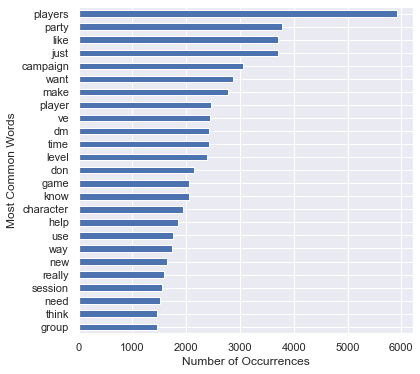

In [7]:
dm_text_df = pd.DataFrame(dm_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
dm_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')

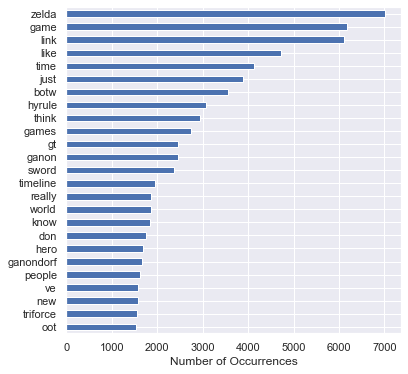

In [8]:
zelda_text_cv = pd.DataFrame(zelda_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
zelda_text_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

In [9]:
custom_words = ['like', 'just', 've', 'don', 'll', 'game', 'games', 'a', 'b', 'c', 'd', 
                'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
                's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'know', 'really', 'new', 'think',
               'things', 'want', 'make', 'way', 'feel', 'world', 'time']

In [10]:
stop_words = text.ENGLISH_STOP_WORDS.union(custom_words)

In [11]:
cvec1 = CountVectorizer(stop_words=stop_words)
dm_text_cv = cvec1.fit_transform(dm_text)
cvec2 = CountVectorizer(stop_words=stop_words)
zelda_text_cv = cvec2.fit_transform(zelda_text)

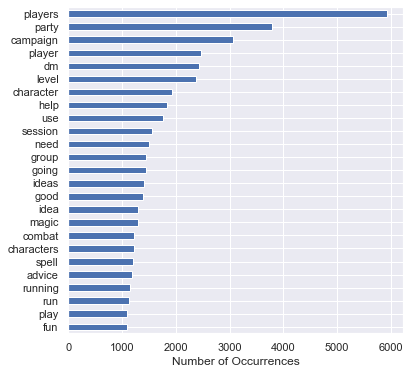

In [12]:
dm_text_df = pd.DataFrame(dm_text_cv.todense(), columns = cvec1.get_feature_names())
plt.figure(figsize=(6,6))
# plot top occuring words
dm_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

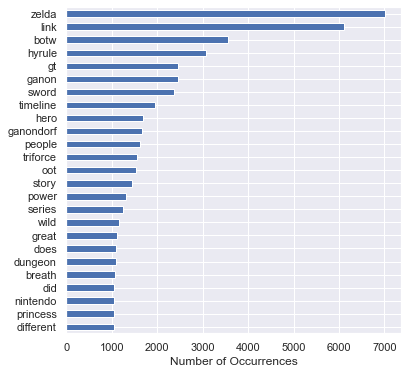

In [13]:
zelda_text_cv = pd.DataFrame(zelda_text_cv.todense(), columns = cvec2.get_feature_names())
plt.figure(figsize=(6,6))
# plot top occuring words
zelda_text_cv.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

---
### Post word count


In [14]:
dmacademy_df

,subreddit,title,text
0,DMAcademy,Seeking seasoned DMs to be guests on interview...,Edit UPDATE Thank you for the robust respo...
1,DMAcademy,TERRAIN and Using it Effectively,TERRAIN and using it Effectively DM Tips Usi...
2,DMAcademy,Know the exact location of something,The players are planning on dropping an evil a...
3,DMAcademy,How to run military basic as a session,I am running a campaign for all intents and pu...
4,DMAcademy,Best time to take breaks how long they should be,Hey just a newbie DM My sessions are usually ...
...,...,...,...
4882,DMAcademy,Urgently need DM support to appropriately eng...,Hi all I am hoping for some advice please I am...
4883,DMAcademy,Do we help with plot here,Mouseketeers go away So i m stuck on a plot p...
4884,DMAcademy,Where to go next Open to suggestions,I have my first group about to finish Lost Min...
4885,DMAcademy,NPCs Playing against type,I m pretty new to DMing and take very long to ...


In [15]:
truezelda_df

,subreddit,title,text
0,truezelda,With the release of the Xenoblade Chronicles ...,There is a VERY small chance that someone in t...
1,truezelda,Reimagining OoT and MM,Here s an idea what if they made pseudo remake...
2,truezelda,Idea An option in the future DLC to toggle Li...,as improbable as that would be with the movie ...
3,truezelda,Reconciling the Hyrule Compendium entry on Dar...,According to the Hyrule Compendium on DBG it s...
4,truezelda,What would you say are the major themes of eac...,You don t have to list all of them I m just in...
...,...,...,...
4107,truezelda,What happened in the story of the missing link...,I don t really like playing games now but I am...
4108,truezelda,Do you think Blind The Thief is a Sheikah,We know that he lived in Kakariko Village
4109,truezelda,Should games such as Tri Force Heroes and Four...,The Zelda timeline is infamous for being convo...
4110,truezelda,Review score predictions for Skyward HD,Title says it all How will it fare With the o...


In [16]:
dma_word_counts = [len(post.split()) for post in dmacademy_df['text']]
zelda_word_counts = [len(post.split()) for post in truezelda_df['text']]

In [17]:
dma_word_counts[:10]

[294, 697, 62, 56, 25, 172, 433, 246, 685, 557]

In [18]:
zelda_word_counts[:10]

[111, 264, 24, 201, 26, 58, 125, 1583, 1, 167]

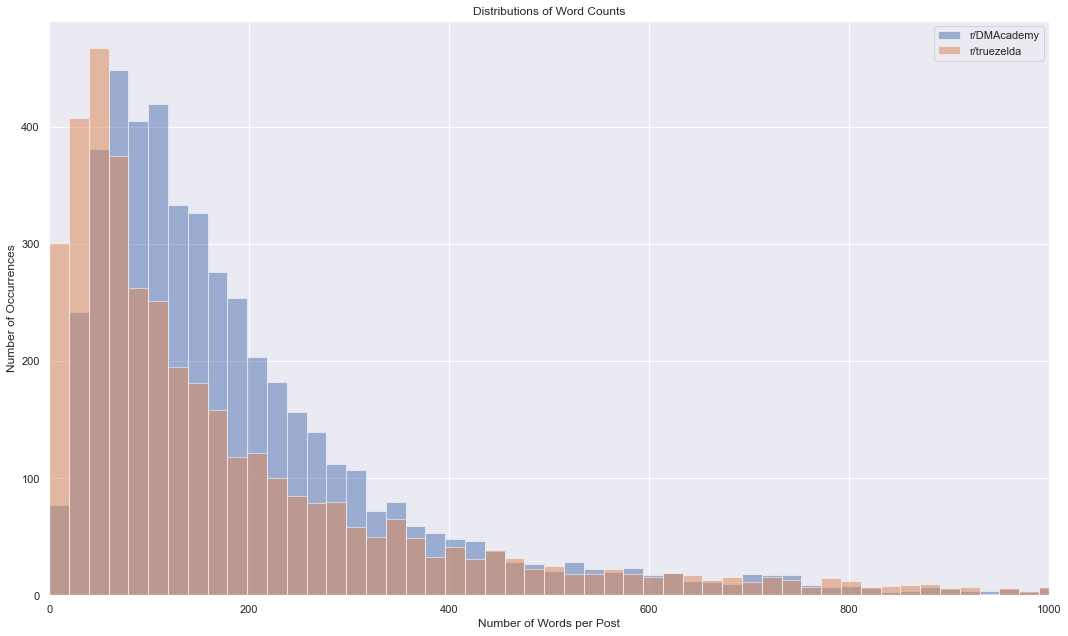

In [19]:
plt.figure(figsize=(15,9))
plt.hist(dma_word_counts, bins=175, alpha=0.5, label='r/DMAcademy');
plt.hist(zelda_word_counts, bins=315, alpha=0.5, label='r/truezelda');
plt.legend()
plt.xlabel('Number of Words per Post')
plt.ylabel('Number of Occurrences')
plt.title('Distributions of Word Counts')
plt.xlim(0, 1000);
plt.tight_layout()
plt.savefig('../visualizations/word_count_dist.png')

---
### Post character length

In [20]:
dma_char_length = [len(post) for post in dmacademy_df['text']]
zelda_char_length = [len(post) for post in truezelda_df['text']]

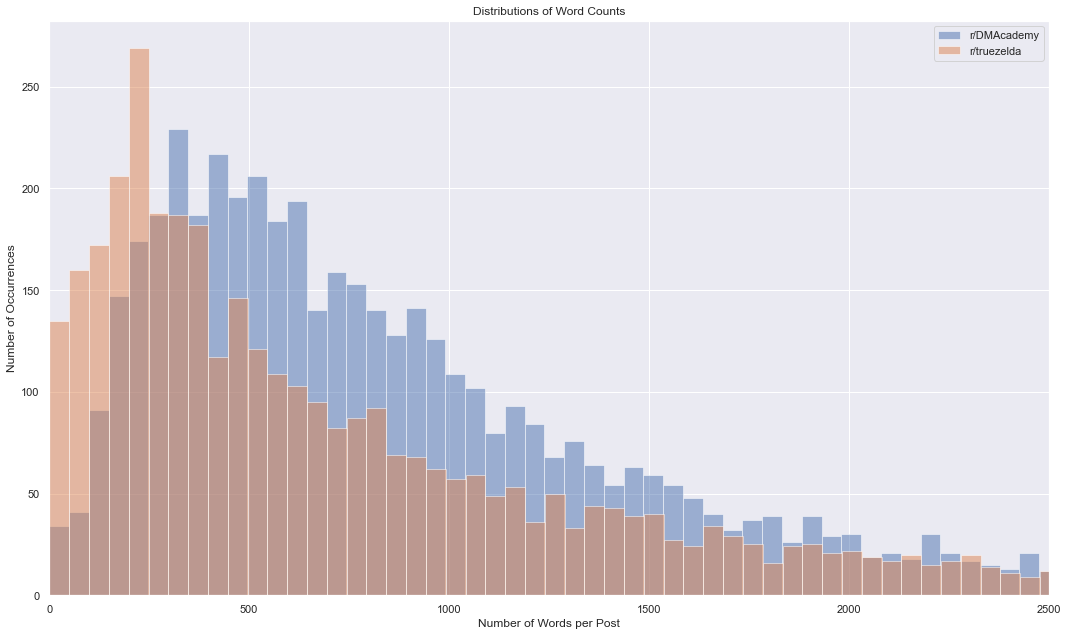

In [21]:
plt.figure(figsize=(15,9))
plt.hist(dma_char_length, bins=400, alpha=0.5, label='r/DMAcademy');
plt.hist(zelda_char_length, bins=650, alpha=0.5, label='r/truezelda');
plt.legend()
plt.xlabel('Number of Words per Post')
plt.ylabel('Number of Occurrences')
plt.title('Distributions of Word Counts')
plt.xlim(0, 2500);
plt.tight_layout()
plt.savefig('../visualizations/character_count_dist.png')

---
### Word tokenizing example

In [22]:
import nltk
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('oceanographers')

'oceanographer'

In [23]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag

In [24]:
dmacademy_df['text'][0]

'  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hyped for the conversations we will have I am currently going through interview applications and preparing to send out follow ups Thanks for your patience    Hello seasoned dungeon masters  I m Nick the host of an upcoming GM interview podcast and I want to talk with you on my show Isn t it about time your epic campaign gets shared with the TTRPG community  I want you the non celebrity GM  or hidden GM if you will  to share your stories and wisdom with the community I think we as a community have something to learn from your experience behind the GM screen  What makes this podcast really fun is that we ll be getting your wisdom out there to other GMs just like you This is the outlet you ve been waiting for to talk about the campaign you poured your heart and soul into I know how painful it is to keep all the cool secrets of your campaign and hidden lore from your PCs My heart is always te

In [25]:
example = dmacademy_df['text'][0]

In [26]:
print(word_tokenize(example.lower()))

['edit', 'update', 'thank', 'you', 'for', 'the', 'robust', 'response', 'i', 've', 'had', 'some', 'great', 'applications', 'so', 'far', 'and', 'i', 'm', 'hyped', 'for', 'the', 'conversations', 'we', 'will', 'have', 'i', 'am', 'currently', 'going', 'through', 'interview', 'applications', 'and', 'preparing', 'to', 'send', 'out', 'follow', 'ups', 'thanks', 'for', 'your', 'patience', 'hello', 'seasoned', 'dungeon', 'masters', 'i', 'm', 'nick', 'the', 'host', 'of', 'an', 'upcoming', 'gm', 'interview', 'podcast', 'and', 'i', 'want', 'to', 'talk', 'with', 'you', 'on', 'my', 'show', 'isn', 't', 'it', 'about', 'time', 'your', 'epic', 'campaign', 'gets', 'shared', 'with', 'the', 'ttrpg', 'community', 'i', 'want', 'you', 'the', 'non', 'celebrity', 'gm', 'or', 'hidden', 'gm', 'if', 'you', 'will', 'to', 'share', 'your', 'stories', 'and', 'wisdom', 'with', 'the', 'community', 'i', 'think', 'we', 'as', 'a', 'community', 'have', 'something', 'to', 'learn', 'from', 'your', 'experience', 'behind', 'the',

In [27]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|S+')
example_tokens = tokenizer.tokenize(example.lower())

print(example_tokens)

['edit', 'update', 'thank', 'you', 'for', 'the', 'robust', 'response', 'i', 've', 'had', 'some', 'great', 'applications', 'so', 'far', 'and', 'i', 'm', 'hyped', 'for', 'the', 'conversations', 'we', 'will', 'have', 'i', 'am', 'currently', 'going', 'through', 'interview', 'applications', 'and', 'preparing', 'to', 'send', 'out', 'follow', 'ups', 'thanks', 'for', 'your', 'patience', 'hello', 'seasoned', 'dungeon', 'masters', 'i', 'm', 'nick', 'the', 'host', 'of', 'an', 'upcoming', 'gm', 'interview', 'podcast', 'and', 'i', 'want', 'to', 'talk', 'with', 'you', 'on', 'my', 'show', 'isn', 't', 'it', 'about', 'time', 'your', 'epic', 'campaign', 'gets', 'shared', 'with', 'the', 'ttrpg', 'community', 'i', 'want', 'you', 'the', 'non', 'celebrity', 'gm', 'or', 'hidden', 'gm', 'if', 'you', 'will', 'to', 'share', 'your', 'stories', 'and', 'wisdom', 'with', 'the', 'community', 'i', 'think', 'we', 'as', 'a', 'community', 'have', 'something', 'to', 'learn', 'from', 'your', 'experience', 'behind', 'the',

In [28]:
# re.findall can find all digits in your text
# don't need to do this because we removed digits previously
# [(re.findall('\d+', word), word) for word in example_tokens]

---
### Sentiment analysis

In [29]:
sentiment = SentimentIntensityAnalyzer()

In [30]:
example

'  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hyped for the conversations we will have I am currently going through interview applications and preparing to send out follow ups Thanks for your patience    Hello seasoned dungeon masters  I m Nick the host of an upcoming GM interview podcast and I want to talk with you on my show Isn t it about time your epic campaign gets shared with the TTRPG community  I want you the non celebrity GM  or hidden GM if you will  to share your stories and wisdom with the community I think we as a community have something to learn from your experience behind the GM screen  What makes this podcast really fun is that we ll be getting your wisdom out there to other GMs just like you This is the outlet you ve been waiting for to talk about the campaign you poured your heart and soul into I know how painful it is to keep all the cool secrets of your campaign and hidden lore from your PCs My heart is always te

In [31]:
sentiment.polarity_scores(example)

{'neg': 0.009, 'neu': 0.779, 'pos': 0.212, 'compound': 0.995}

In [32]:
dmacademy_sentiment = {'neg':0, 'neu':0, 'pos':0}
sample_dmacademy = dmacademy_df[:20]

# get polarity scores for each row in our dataframe
for row in sample_dmacademy['text']:
    scores = sentiment.polarity_scores(row)
    dmacademy_sentiment['neg'] += scores['neg']
    dmacademy_sentiment['neu'] += scores['neu']
    dmacademy_sentiment['pos'] += scores['pos']

# get the average for each
for key in dmacademy_sentiment.keys():
    dmacademy_sentiment[key] = dmacademy_sentiment[key]/len(sample_dmacademy)
print(dmacademy_sentiment)

# prove that these add up to close to 1
total = 0
for key in dmacademy_sentiment.keys():
    total += dmacademy_sentiment[key]
total

{'neg': 0.08295, 'neu': 0.7989500000000002, 'pos': 0.11800000000000002}


0.9999000000000001

In [33]:
def get_polarity(df):
    # create polarity dictionary
    polarity_dict = {'Negative':0, 'Neutral':0, 'Positive':0}
    
    # get polarity scores for each row in our dataframe
    for row in df['text']:
        scores = sentiment.polarity_scores(row)
        polarity_dict['Negative'] += scores['neg']
        polarity_dict['Neutral'] += scores['neu']
        polarity_dict['Positive'] += scores['pos']

    # get the average scores 
    for key in polarity_dict.keys():
        polarity_dict[key] = polarity_dict[key]/len(df)
        
    return polarity_dict

In [34]:
get_polarity(sample_dmacademy)

{'Negative': 0.08295,
 'Neutral': 0.7989500000000002,
 'Positive': 0.11800000000000002}

In [35]:
dmacademy_polarity = get_polarity(dmacademy_df)
dmacademy_polarity

{'Negative': 0.07945631266625777,
 'Neutral': 0.7892070800081862,
 'Positive': 0.1309263351749538}

In [36]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(dmacademy_polarity.keys(), dmacademy_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', 'r/DMAcademy'])

In [37]:
polarity_df

,score_type,r/DMAcademy
0,Negative,0.079456
1,Neutral,0.789207
2,Positive,0.130926


In [38]:
truezelda_polarity = get_polarity(truezelda_df)
truezelda_polarity

{'Negative': 0.05893652723735403,
 'Neutral': 0.8090695525291832,
 'Positive': 0.11982855058365775}

In [39]:
polarity_df['r/truezelda'] = list(truezelda_polarity.values())

In [40]:
polarity_df

,score_type,r/DMAcademy,r/truezelda
0,Negative,0.079456,0.058937
1,Neutral,0.789207,0.809070
2,Positive,0.130926,0.119829


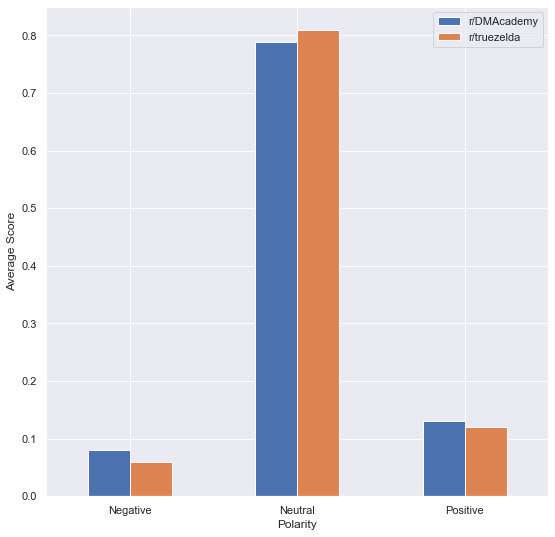

In [41]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['r/DMAcademy', 'r/truezelda'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity')
plt.ylabel('Average Score')
plt.xticks(rotation=0);

Now that we've got a small tidy dataframe of our average polarity scores for each subreddit, let's visualize! 

In [42]:
polarity_df.index

RangeIndex(start=0, stop=3, step=1)

--- 
# Section 2: PoliticalDiscussion 2012 and 2020 text analysis

### Read in the clean data files, again

In [43]:
poli_dis_2012_df = pd.read_csv('../data/clean_poli_dis_2012.csv')
poli_dis_2020_df = pd.read_csv('../data/clean_poli_dis_2020.csv')

### Identify potential stopwords

In [44]:
poli_dis_2012_df.dropna(inplace=True)
poli_dis_2020_df.dropna(inplace=True)

In [45]:
poli_2012_text = poli_dis_2012_df['text']
poli_2020_text = poli_dis_2020_df['text']

In [46]:
# get standard stopwords

# uncomment the line below to get a longggg list of words
# text.ENGLISH_STOP_WORDS

In [47]:
cvec1 = CountVectorizer(stop_words='english')
poli_2012_text_cv = cvec1.fit_transform(poli_2012_text)
cvec2 = CountVectorizer(stop_words='english')
poli_2020_text_cv = cvec2.fit_transform(poli_2020_text)

In [48]:
# print some to make sure it worked
cvec1.get_feature_names()[1000:1010]

['baked',
 'balance',
 'balanced',
 'balances',
 'balancing',
 'baldus',
 'bales',
 'balkanization',
 'ball',
 'ballistic']

Text(0, 0.5, 'Most Common Words')

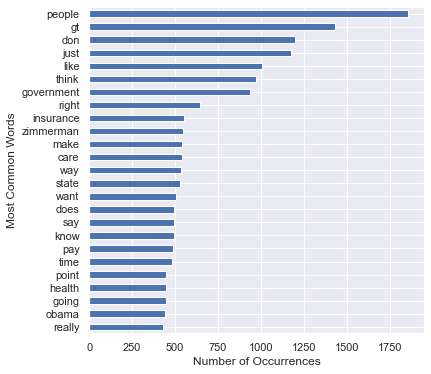

In [49]:
poli_2012_text_df = pd.DataFrame(poli_2012_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2012_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')

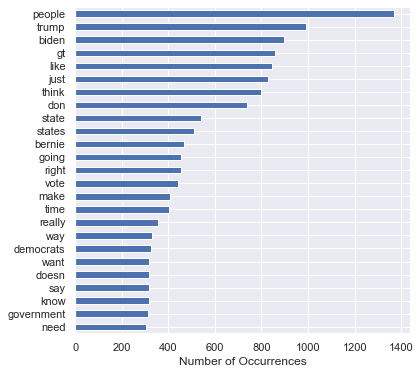

In [50]:
poli_2020_text_df = pd.DataFrame(poli_2020_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2020_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

In [51]:
stop_words = text.ENGLISH_STOP_WORDS.union(custom_words)

In [52]:
cvec1 = CountVectorizer(stop_words=stop_words)
poli_2012_text_cv = cvec1.fit_transform(poli_2012_text)
cvec2 = CountVectorizer(stop_words=stop_words)
poli_2020_text_cv = cvec2.fit_transform(poli_2020_text)

Text(0, 0.5, 'Most Common Words')

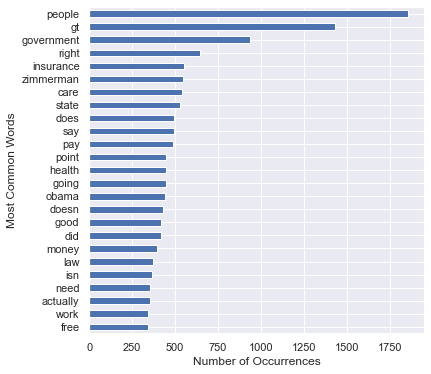

In [53]:
poli_2012_text_df = pd.DataFrame(poli_2012_text_cv.todense(), columns = cvec1.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2012_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()
plt.ylabel('Most Common Words')

In [54]:
custom_words = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 
                'people', 'gt', 'don', 'll', 've', 'just', 'like', 'think', 'state',
               'government', 'right', 'make', 'way', 'want', 'does', 'doesn', 
               'say', 'know', 'time', 'going', 'really', 'thing', 'didn', 'isn',
               'did', 'actually', 'vote', 'care', 'things', 'work', 'money', 
               'said', 'good', 'point', 'need', 'states', 'lot', 'years']

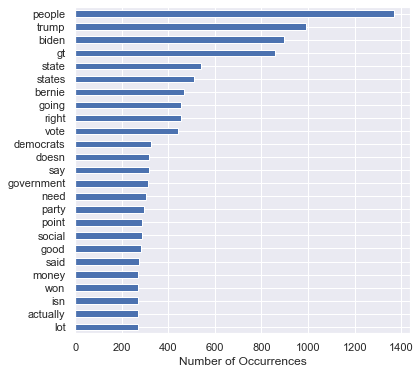

In [55]:
poli_2020_text_df = pd.DataFrame(poli_2020_text_cv.todense(), columns = cvec2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(6,6))
poli_2020_text_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

In [56]:
poli_dis_2012_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [57]:
poli_dis_2012_df.dropna(inplace=True)
poli_dis_2012_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [58]:
poli_dis_2020_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [59]:
X = poli_dis_2012_df['text']

In [60]:
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)

In [61]:
cvec.get_feature_names()[1000:1010]

['baked',
 'balance',
 'balanced',
 'balances',
 'balancing',
 'baldus',
 'bales',
 'balkanization',
 'ball',
 'ballistic']

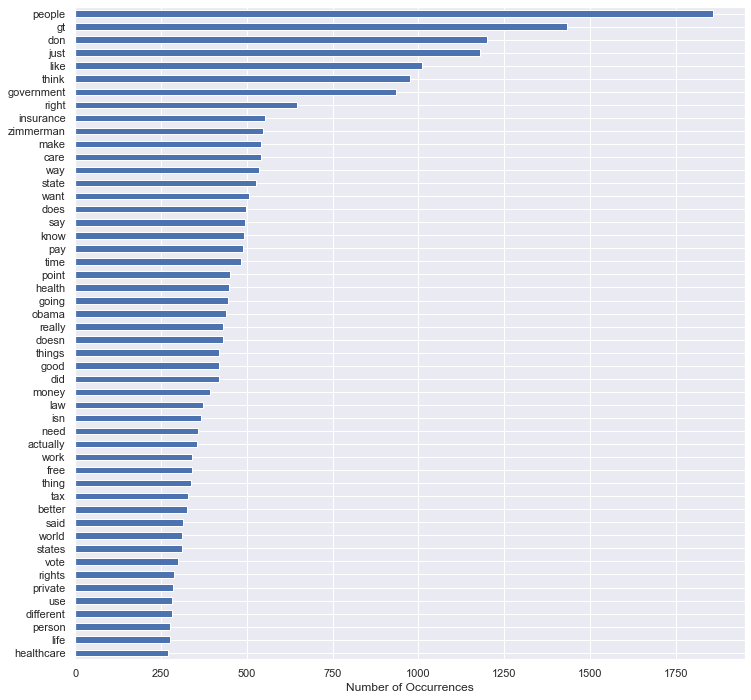

In [62]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,12))
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

Words to consider removing: _________

---
### Post word count


In [63]:
poli_dis_2012_counts = [len(post.split()) for post in poli_dis_2012_df['text']]
poli_dis_2020_counts = [len(post.split()) for post in poli_dis_2020_df['text']]

In [64]:
poli_dis_2012_counts[:10]

[19, 70, 16, 27, 12, 10, 16, 107, 66, 217]

In [65]:
poli_dis_2020_counts[:10]

[33, 38, 77, 81, 45, 61, 21, 165, 44, 85]

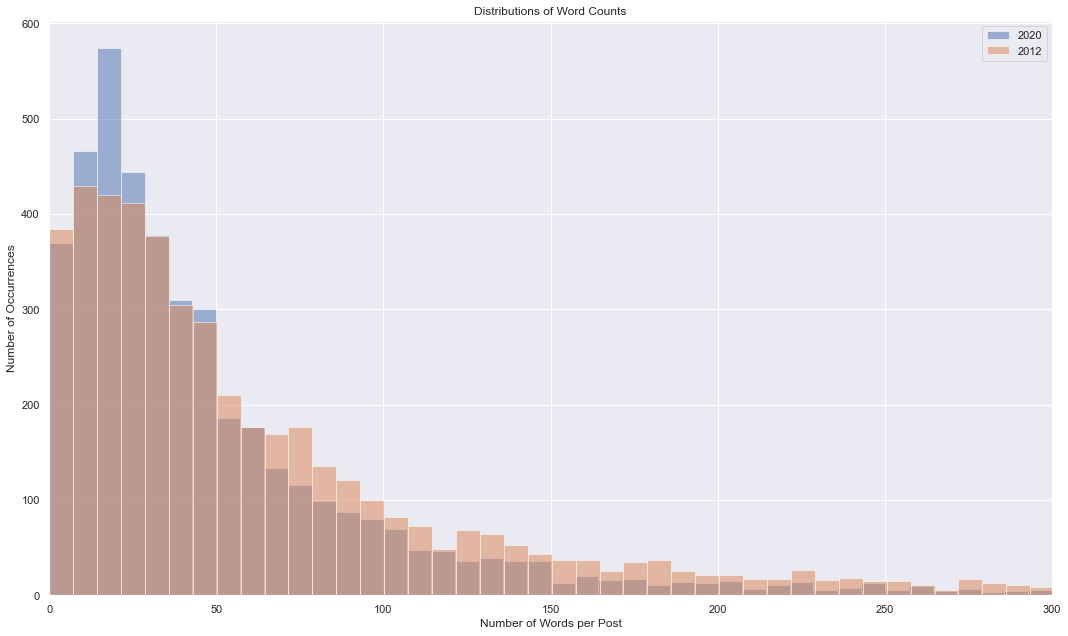

In [66]:
plt.figure(figsize=(15,9))
plt.hist(poli_dis_2020_counts, bins=125, alpha=0.5, label='2020');
plt.hist(poli_dis_2012_counts, bins=235, alpha=0.5, label='2012');
plt.legend()
plt.xlabel('Number of Words per Post')
plt.ylabel('Number of Occurrences')
plt.title('Distributions of Word Counts')
plt.xlim(0, 300);
plt.tight_layout()
plt.savefig('../visualizations/poli_word_count_dist.png')

---
### Post character length

In [67]:
poli_dis_2012_char_length = [len(post) for post in poli_dis_2012_df['text']]
poli_dis_2020_char_length = [len(post) for post in poli_dis_2020_df['text']]

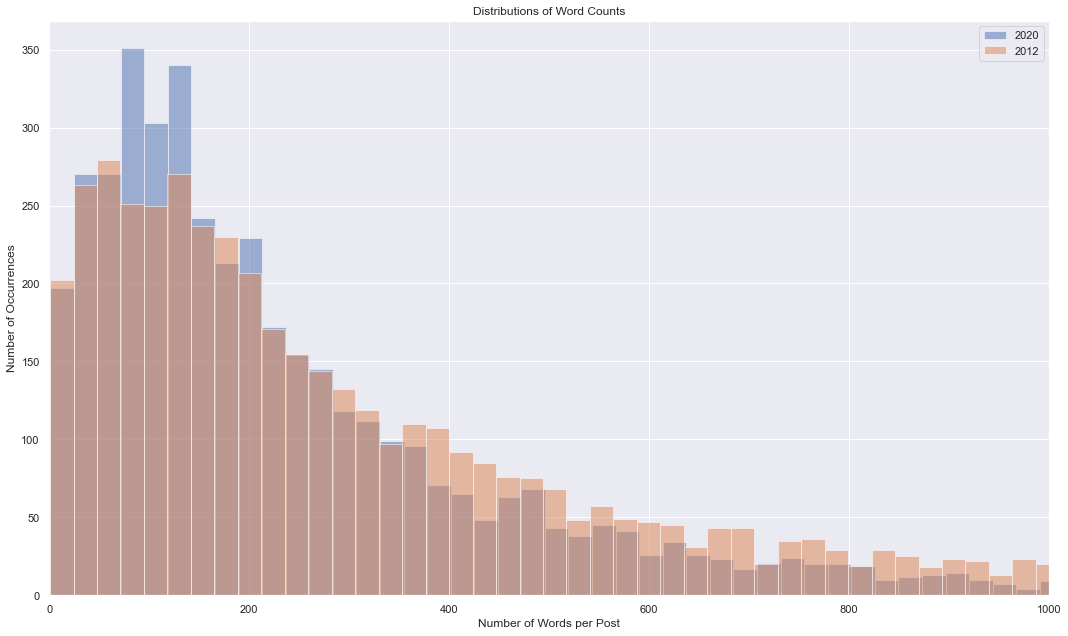

In [68]:
plt.figure(figsize=(15,9))
plt.hist(poli_dis_2020_char_length, bins=200, alpha=0.5, label='2020');
plt.hist(poli_dis_2012_char_length, bins=410, alpha=0.5, label='2012');
plt.legend()
plt.xlabel('Number of Words per Post')
plt.ylabel('Number of Occurrences')
plt.title('Distributions of Word Counts')
plt.xlim(0, 1000);
plt.tight_layout()
plt.savefig('../visualizations/poli_character_count_dist.png')

---
### Sentiment analysis

In [69]:
poli_dis_2012_polarity = get_polarity(poli_dis_2012_df)
poli_dis_2012_polarity

{'Negative': 0.0993024091293325,
 'Neutral': 0.7756876584953505,
 'Positive': 0.12141018596787831}

In [70]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(poli_dis_2012_polarity.keys(), poli_dis_2012_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', '2012'])

In [71]:
polarity_df

,score_type,2012
0,Negative,0.099302
1,Neutral,0.775688
2,Positive,0.121410


In [72]:
poli_dis_2020_polarity = get_polarity(poli_dis_2020_df)
poli_dis_2020_polarity

{'Negative': 0.08580459503365054,
 'Neutral': 0.7918623810628913,
 'Positive': 0.11931933163146914}

In [73]:
polarity_df['2020'] = list(poli_dis_2020_polarity.values())

In [74]:
polarity_df

,score_type,2012,2020
0,Negative,0.099302,0.085805
1,Neutral,0.775688,0.791862
2,Positive,0.121410,0.119319


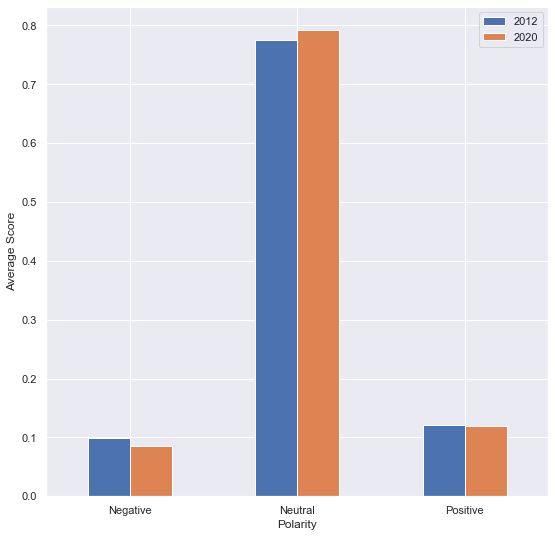

In [75]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['2012', '2020'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity')
plt.ylabel('Average Score')
plt.xticks(rotation=0);

---
### Extra stuff
Thought about seeing how many words start with each letter of the alphabet for each of my subreddits. r/truezelda would have a lot more z words, it'd be cool! 

In [76]:
poli_dis_2020_df.loc[poli_dis_2020_df['text'].str.lower().str.contains('april fool')]['text']

Series([], Name: text, dtype: object)

In [77]:
poli_dis_2012_df.loc[poli_dis_2012_df['text'].str.lower().str.contains('april fool')]['text']

Series([], Name: text, dtype: object)

In [78]:
poli_dis_2012_df.dropna(inplace=True)

In [79]:
for row in truezelda_df.loc[truezelda_df['text'].str.lower().str.contains('april fool')]['text']:
    print(row)

  So what are we   some kind of  shitpost thread      As always this thread is for anything you want questions topics you don t think deserve their own thread Meta stuff topics prompts unrelated to Legend of Zelda you want to talk about with this subreddit s members etc       This thread s prompt is     Would you rather be granted  wishes of your choice  years from today or be granted  wish today         How patient vs how greedy are you      Standard wish rules applies no wishing for infinite wishes no matter what logic loop work around you use for it    Also as a BoNuS I wanna bring attention  Reddit s newest  April Fools experiment     It aint as amazing as  r place but it is interesting in another way    And speaking of circles of trust I think this is self explanatory   but all sharing asking of circle passwords on this subreddit needs to stay within this thread      This BoNuS was sponsored by  r CircleofTrust       LINK   to previous thread 
For ages I ve been considering making

In [80]:
for row in dmacademy_df.loc[dmacademy_df['text'].str.lower().str.contains('april fool')]['text']:
    print(row)

So for those of you who don t know on D D Wiki they have a large amount of homebrew material including  April Fools content which are basically  classes  and  Races   that aren t meant to be played whether due to them just being a joke or due to them being   WAY  too powerful for use  Doesn t that sound like fun  I think so and I thought it would be a good break for my players to have a completely insane one shot where they get to be  f gt  ucking  lt ridiculous What I want to know is if there are existing one shots that would be a good fit for this type of game Here are some details for the game   Characters will be level   The one shot just needs to be less than  hours We usually play long  There would be an upwards of  people potentially less  I know this is kinda a stupid idea but that s what I m going for Thanks in advance 


In [81]:
letter_words_dict = {'s':[25333,10.6],
'p':[24472,10.3],
'c':[19851,8.37],
'a':[16869,7.11],
'u':[16520,6.97],
't':[12976,5.47],
'm':[12503,5.27],
'b':[11117,4.69],
'd':[11107,4.68],
'r':[9918,4.18],
'h':[9105,3.84],
'i':[8819,3.72],
'e':[8748,3.69],
'o':[7877,3.32],
'f':[7152,3.01],
'g':[6969,2.94],
'n':[6758,2.85],
'l':[6322,2.66],
'w':[4074,1.71],
'v':[3416,1.44],
'k':[2234,0.94],
'j':[1637,0.69],
'q':[1179,0.49],
'z':[963,0.40],
'y':[680,0.28],
'x':[384,0.16]}